📂 Found RAW files: ['raw_1.csv', 'raw_10.csv', 'raw_20.csv', 'raw_40.csv', 'raw_5.csv']
📂 Found OPT files: ['opt_1.csv', 'opt_10.csv', 'opt_20.csv', 'opt_40.csv', 'opt_5.csv']
✅ Plots generate: fps_vs_count.png, cpu_vs_count.png, mem_vs_count.png


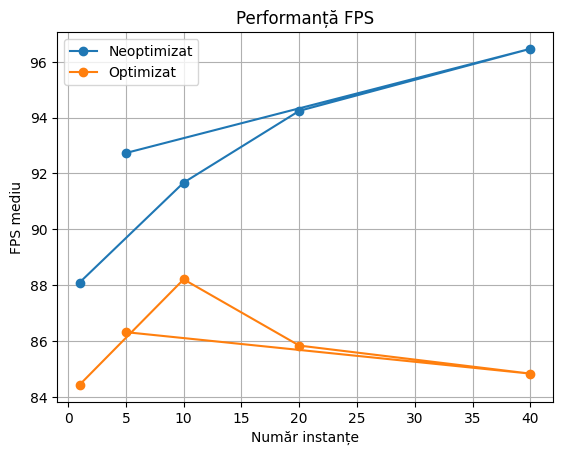

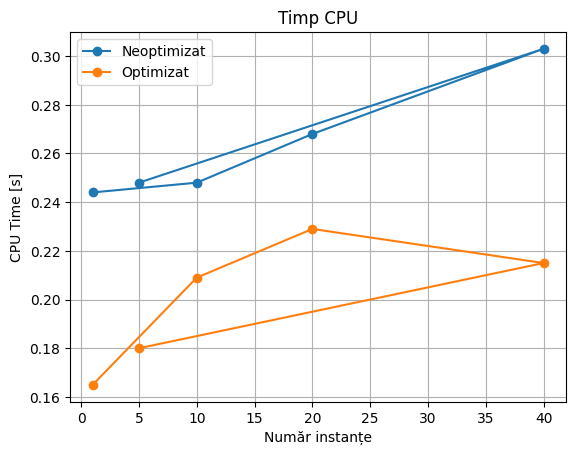

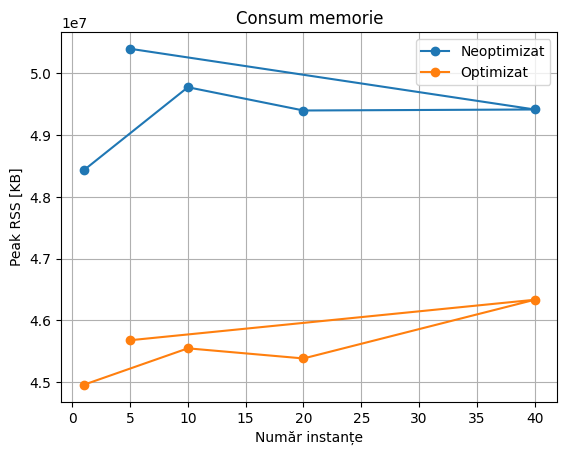

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def read_metrics_from_file(filename):
    df = pd.read_csv(filename)

    df_numeric = df[df['frame'].apply(lambda x: str(x).isdigit())]
    avg_dt = df_numeric['dt_ms'].mean()
    fps = 1000.0 / avg_dt if avg_dt > 0 else 0

    cpu_line = df[df['frame'] == 'cpu_time']
    rss_line = df[df['frame'] == 'peak_rss_kb']

    cpu = float(cpu_line['dt_ms'].values[0]) if not cpu_line.empty else None
    rss = float(rss_line['dt_ms'].values[0]) if not rss_line.empty else None

    # Extract number from filename (e.g., raw_10.csv -> 10)
    count = int(filename.split('_')[1].split('.')[0])

    return {
        'count': count,
        'avg_fps': fps,
        'cpu_time': cpu,
        'peak_rss_kb': rss
    }

# List all files in the current directory
all_files = os.listdir('.')

# Select raw and opt files explicitly
raw_files = sorted([f for f in all_files if f.startswith('raw_') and f.endswith('.csv')])
opt_files = sorted([f for f in all_files if f.startswith('opt_') and f.endswith('.csv')])

# Make sure we actually found them
print("📂 Found RAW files:", raw_files)
print("📂 Found OPT files:", opt_files)

raw_data = [read_metrics_from_file(f) for f in raw_files]
opt_data = [read_metrics_from_file(f) for f in opt_files]

raw_df = pd.DataFrame(raw_data)
opt_df = pd.DataFrame(opt_data)

# === FPS PLOT ===
plt.figure()
plt.plot(raw_df['count'], raw_df['avg_fps'], 'o-', label='Neoptimizat')
plt.plot(opt_df['count'], opt_df['avg_fps'], 'o-', label='Optimizat')
plt.xlabel('Număr instanțe')
plt.ylabel('FPS mediu')
plt.title('Performanță FPS')
plt.grid(True)
plt.legend()
plt.savefig("fps_vs_count.png")

# === CPU TIME ===
plt.figure()
plt.plot(raw_df['count'], raw_df['cpu_time'], 'o-', label='Neoptimizat')
plt.plot(opt_df['count'], opt_df['cpu_time'], 'o-', label='Optimizat')
plt.xlabel('Număr instanțe')
plt.ylabel('CPU Time [s]')
plt.title('Timp CPU')
plt.grid(True)
plt.legend()
plt.savefig("cpu_vs_count.png")

# === MEMORIE ===
plt.figure()
plt.plot(raw_df['count'], raw_df['peak_rss_kb'], 'o-', label='Neoptimizat')
plt.plot(opt_df['count'], opt_df['peak_rss_kb'], 'o-', label='Optimizat')
plt.xlabel('Număr instanțe')
plt.ylabel('Peak RSS [KB]')
plt.title('Consum memorie')
plt.grid(True)
plt.legend()
plt.savefig("mem_vs_count.png")

print("✅ Plots generate: fps_vs_count.png, cpu_vs_count.png, mem_vs_count.png")